### Read Data

In [3]:
# Install necessary libraries
# !pip install torch torchvision torchaudio pandas scikit-learn

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
# df_children_books_final = pd.read_csv('df_children_books_final.csv')
# df_children_books_final_encoded = pd.read_csv('df_children_books_final_encoded.csv')
df_interactions_final_merged = pd.read_csv('df_interactions_final_merged.csv')

In [9]:
df = df_interactions_final_merged.groupby(['user_id']).count().sort_values('review_text_incomplete')

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [13]:
np.quantile(df['review_text_incomplete'], [0,0.25,0.5,0.75,1])

array([   0.,    0.,    0.,    0., 4483.])

<Axes: xlabel='review_text_incomplete'>

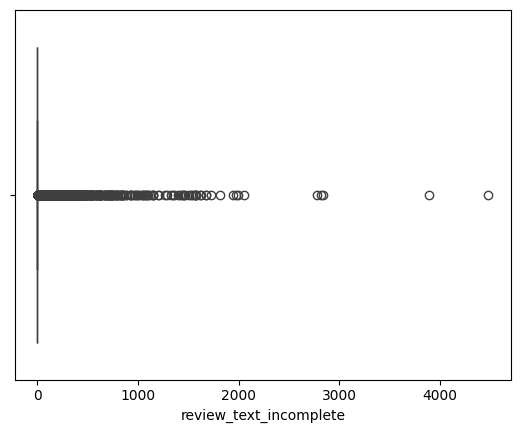

In [11]:
sns.boxplot(x='review_text_incomplete', data=df)

In [39]:
df_children_books_final_encoded.head(3)

,isbn,isbn13,book_id,title,authors,num_pages,description,is_ebook,popular_shelves,average_rating,...,lang_tha,lang_tur,lang_ukr,lang_vie,lang_vls,lang_yid,lang_zho,length_long,length_medium,length_short
0,1599150603,9781599150604,287141,The Aeneid for Boys and Girls,"[{'author_id': '3041852', 'role': ''}]",162.0,"Relates in vigorous prose the tale of Aeneas, ...",False,"[{'count': '56', 'name': 'to-read'}, {'count':...",4.13,...,False,False,False,False,False,False,False,False,True,False
1,1934876569,9781934876565,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,"[{'author_id': '19158', 'role': ''}]",216.0,"To Kara's astonishment, she discovers that a p...",False,"[{'count': '515', 'name': 'to-read'}, {'count'...",4.22,...,False,False,False,False,False,False,False,False,True,False
2,0590417010,9780590417013,89378,Dog Heaven,"[{'author_id': '5411', 'role': ''}]",40.0,In Newbery Medalist Cynthia Rylant's classic b...,False,"[{'count': '450', 'name': 'to-read'}, {'count'...",4.43,...,False,False,False,False,False,False,False,False,False,True


In [20]:
df_interactions_final_merged.head(3)

,user_id,book_id,review_id,rating,review_text_incomplete,date_added,n_votes,review_age,processed_review,sentiment
0,8842281e1d1347389f2ab93d60773d4d,23310161,f4b4b050f4be00e9283c92a814af2670,4,Fun sequel to the original.,2015-11-17 19:37:35+00:00,7.0,3248,fun sequel original,0.680800
1,8842281e1d1347389f2ab93d60773d4d,18296097,bc9cff98f54be3b2b8c5b34598a7546c,5,NaN,2015-09-21 15:16:57+00:00,NaN,3305,NaN,0.574139
2,8842281e1d1347389f2ab93d60773d4d,817720,75fd46041466ceb406b7fd69b089b9c5,5,NaN,2015-05-21 04:29:23+00:00,NaN,3429,NaN,0.574139


### Encoder

In [21]:
# Preprocessing
userid_encoder = LabelEncoder()
bookid_encoder = LabelEncoder()

df_interactions_final_merged['user_id'] = userid_encoder.fit_transform(df_interactions_final_merged['user_id'])
df_interactions_final_merged['book_id'] = bookid_encoder.fit_transform(df_interactions_final_merged['book_id'])

### Split train and test sets

In [22]:
train_data = []
test_data = []

In [23]:
for user_id, group in df_interactions_final_merged.groupby('user_id'):
    split_idx = int(len(group) * 0.8) 
    train_data.append(group.iloc[:split_idx])
    test_data.append(group.iloc[split_idx:])

train_data = pd.concat(train_data, ignore_index=True)
test_data = pd.concat(test_data, ignore_index=True)

In [24]:
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (5054073, 10)
Testing data shape: (1572916, 10)


In [25]:

for user_id in range(5): 
  user_train = train_data[train_data['user_id'] == user_id]
  user_test = test_data[test_data['user_id'] == user_id]
  print(f"\nUser {user_id}:")
  print(f"  Train samples: {len(user_train)}")
  print(f"  Test samples: {len(user_test)}")
  print(f"  Train ratio: {len(user_train) / (len(user_train) + len(user_test)):.2f}")


User 0:
  Train samples: 4
  Test samples: 1
  Train ratio: 0.80

User 1:
  Train samples: 27
  Test samples: 7
  Train ratio: 0.79

User 2:
  Train samples: 1
  Test samples: 1
  Train ratio: 0.50

User 3:
  Train samples: 1
  Test samples: 1
  Train ratio: 0.50

User 4:
  Train samples: 4
  Test samples: 1
  Train ratio: 0.80


#### Filtering out users and books in the test set that do not appear in the training set.

This is done so that we can see if our model has learnt user's previous item interactions and can recommend relevant books.

In [26]:
# Get unique users and items from the training data
train_users = set(train_data['user_id'].unique())
train_items = set(train_data['book_id'].unique())

# Filter the test set
filtered_test_data = test_data[
    test_data['user_id'].isin(train_users) & test_data['book_id'].isin(train_items)
]

In [27]:
print(len(filtered_test_data))
filtered_test_data.head()

1440373


,user_id,book_id,review_id,rating,review_text_incomplete,date_added,n_votes,review_age,processed_review,sentiment
0,0,480,b5c7c0ca89779a65111ae924633ecf38,1,NaN,2014-12-07 20:11:06+00:00,NaN,3593,NaN,-0.018937
1,1,53356,5c0f20ebfbd0cfdddac5fab9f9523346,4,NaN,2013-04-06 01:26:16+00:00,NaN,4204,NaN,0.527973
2,1,32555,8b3b8f80e33fa6ebaded76a15b8d71d3,4,NaN,2013-04-06 01:26:10+00:00,NaN,4204,NaN,0.527973
3,1,487,69b2e638da62a121dc91c8295453dcda,4,NaN,2013-04-06 01:24:19+00:00,NaN,4204,NaN,0.527973
4,1,11363,afae540b29bbf5b0cccae5174d6041d2,2,NaN,2013-04-06 01:24:11+00:00,NaN,4204,NaN,0.208501


### Dataloader

In [36]:
class BooksDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return {
            'user_id': torch.tensor(row['user_id'], dtype=torch.long),
            'book_id': torch.tensor(row['book_id'], dtype=torch.long),
            'sentiment': torch.tensor(row['sentiment'], dtype=torch.float)
        }

# Create DataLoader
batch_size = 2048

train_dataset = BooksDataset(train_data)
test_dataset = BooksDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### NeuMF model with GMF and MLP

In [37]:
# Define the NCF model with GMF and MLP for Books Data
class NCF(nn.Module):
    def __init__(self, num_users, num_books, embedding_dim):
        super(NCF, self).__init__()
        # GMF Components
        self.user_embeddings_gmf = nn.Embedding(num_users, embedding_dim)
        self.book_embeddings_gmf = nn.Embedding(num_books, embedding_dim)

        # MLP Components
        self.user_embeddings_mlp = nn.Embedding(num_users, embedding_dim)
        self.book_embeddings_mlp = nn.Embedding(num_books, embedding_dim)

        self.fc1_mlp = nn.Linear(2 * embedding_dim, 128)
        self.fc2_mlp = nn.Linear(128, 64)

        # Final layers
        self.fc1_combined = nn.Linear(embedding_dim + 64, 128)
        self.fc2_combined = nn.Linear(128, 1)

    def forward(self, user_id, book_id):
        # GMF
        user_emb_gmf = self.user_embeddings_gmf(user_id)
        book_emb_gmf = self.book_embeddings_gmf(book_id)
        gmf_output = user_emb_gmf * book_emb_gmf

        # MLP
        user_emb_mlp = self.user_embeddings_mlp(user_id)
        book_emb_mlp = self.book_embeddings_mlp(book_id)
        mlp_input = torch.cat([user_emb_mlp, book_emb_mlp], dim=-1)
        mlp_output = torch.relu(self.fc1_mlp(mlp_input))
        mlp_output = torch.relu(self.fc2_mlp(mlp_output))

        # Combine GMF and MLP outputs
        combined_input = torch.cat([gmf_output, mlp_output], dim=-1)
        combined_output = torch.relu(self.fc1_combined(combined_input))
        combined_output = torch.relu(self.fc2_combined(combined_output)) * 4 + 1  # To match rating scale

        return combined_output.squeeze()

### Model Training

In [1]:
# Instantiate and train the model
embedding_dim = 32
num_users = len(userid_encoder.classes_) 
num_books = len(bookid_encoder.classes_)  

model = NCF(num_users, num_books, embedding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Training
num_epochs = 5
for epoch in range(num_epochs):
    # print('epoch:', epoch)
    model.train()
    epoch_loss = 0
    batch_no = 1
    for batch in train_loader:
        user_id = batch['user_id']
        book_id = batch['book_id']
        sentiment = batch['sentiment']

        optimizer.zero_grad()
        outputs = model(user_id, book_id)
        loss = criterion(outputs, sentiment)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_no += 1

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_data)}')

# Evaluation
model.eval()
test_loss = 0
with torch.no_grad():
    total_loss = 0
    for batch in test_loader:
        user_id = batch['user_id']
        book_id = batch['book_id']
        sentiment = batch['sentiment']

        outputs = model(user_id, book_id)
        loss = criterion(outputs, sentiment)

        total_loss += loss.item()

    test_loss = total_loss / len(test_data)
    print(f'Test Loss: {test_loss}')

NameError: name 'userid_encoder' is not defined

### Generate Predictions

Use trained GMF+MLP model to generate predictions on the test set.

In [77]:
def generate_predictions(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            user_id = batch['user_id']
            book_id = batch['book_id']
            outputs = model(user_id, book_id)
            predictions.extend(zip(user_id.numpy(), book_id.numpy(), outputs.numpy()))
    return predictions

# Generate predictions
test_predictions = generate_predictions(model, test_loader)

### Evaluate

In [78]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer

# calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
    # calculate precision-recall curve
    p, r, _ = precision_recall_curve(y_true, probas_pred)
    return auc(r, p)

In [79]:
# evaluate a model
def evaluate_model(X, y, model):

    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation the metric
    metric = make_scorer(pr_auc, needs_proba=True)

    # evaluate model
    #scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)

    # Perform cross-validation
    results = cross_validate(model, X, y, scoring=metric, cv=cv, return_train_score=False, return_estimator=True)

    # Extract scores and trained models
    scores = results['test_score']
    trained_model = results['estimator']
    return scores, trained_model

In [ ]:
# scores, trained_model = evaluate_model(X, y, models[i])
# print('%.3f (%.3f)' % (mean(scores), std(scores)))